# **Problem Statement**
Based on a user profile (i.e. personal data, and historical loan information) determine if a user is credit worthy.

### Handling Imports

In [87]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, VotingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import time

### The Data

The data was retrieved from https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction and contains Credit Card Dataset for Machine Learning!

In [90]:
# Load the Application record data set
application_data = pd.read_csv('data/application_record.csv')

application_data.info()
print(f'Starting dataframe shape {application_data.shape} - i.e Rows {application_data.shape[0]} and Columns {application_data.shape[1]}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [91]:
application_data.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [94]:
application_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [96]:
# Load the Credit record data set

credit_records_data = pd.read_csv('data/credit_record.csv')
credit_records_data.info()
print(f'Starting dataframe shape {credit_records_data.shape} - i.e Rows {credit_records_data.shape[0]} and Columns {credit_records_data.shape[1]}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB
Starting dataframe shape (1048575, 3) - i.e Rows 1048575 and Columns 3


In [98]:
credit_records_data.describe()

,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


In [100]:
credit_records_data.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


### Merging Data sets
We will merge the two datasets on the basis of common `ID`

In [103]:
data = pd.merge(application_data, credit_records_data, on='ID' , how='inner')

In [105]:
data.info()
print(f'Starting dataframe shape {data.shape} - i.e Rows {data.shape[0]} and Columns {data.shape[1]}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_MOBIL           777715 non-null  int64  
 13  FLAG_WORK_PHONE      777715 non-null  int64  
 14  FLAG_PHONE           777715 non-null  int64  
 15  FLAG_EMAIL       

In [107]:
data.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE
count,7.777150e+05,777715.000000,7.777150e+05,777715.000000,777715.000000,777715.0,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000
mean,5.078743e+06,0.428082,1.885348e+05,-16124.937046,57775.825016,1.0,0.231818,0.300965,0.091675,2.208837,-19.373564
std,4.180442e+04,0.745755,1.016225e+05,4104.304018,136471.735391,0.0,0.421993,0.458678,0.288567,0.907380,14.082208
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.044568e+06,0.000000,1.215000e+05,-19453.000000,-3292.000000,1.0,0.000000,0.000000,0.000000,2.000000,-29.000000
50%,5.069530e+06,0.000000,1.620000e+05,-15760.000000,-1682.000000,1.0,0.000000,0.000000,0.000000,2.000000,-17.000000
75%,5.115551e+06,1.000000,2.250000e+05,-12716.000000,-431.000000,1.0,0.000000,1.000000,0.000000,3.000000,-8.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


In [109]:
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


Null values
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        240048
CNT_FAM_MEMBERS             0
MONTHS_BALANCE              0
STATUS                      0
dtype: int64
Unique values per column
ID                     36457
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         265
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              7183
DAYS_EMPLOYED           3640
FL

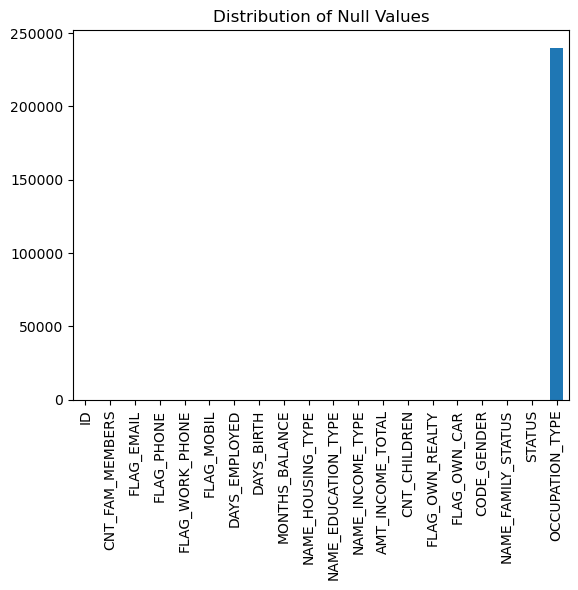

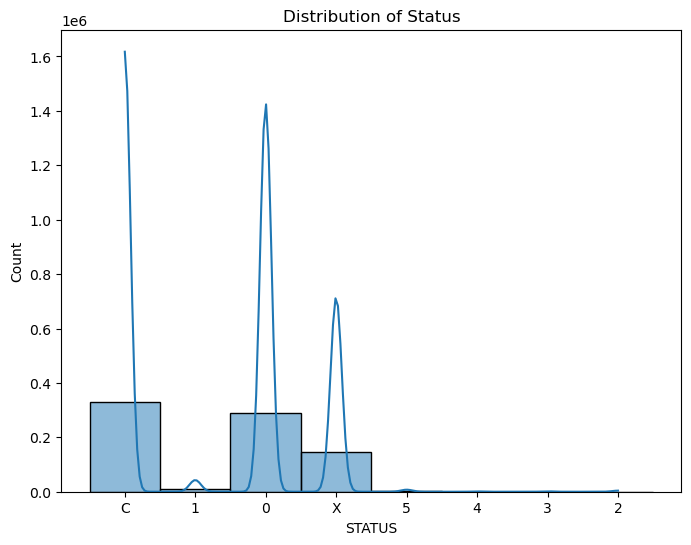

In [111]:
# Explore null or missing values
print('Null values')
print(data.isnull().sum())
plt.title('Distribution of Null Values')
data.isnull().sum().sort_values().plot(kind = 'bar')

# Check the number of unique values of each column
print('Unique values per column')
print(data.nunique())

# Explore price column
print(data[['STATUS']].value_counts())

# Visual exploration for our target Price
plt.figure(figsize=(8, 6))
sns.histplot(data=data['STATUS'], bins=10, kde=True)
plt.title('Distribution of Status')
plt.show()

### Data Observations
1. We have a total of Rows 777715 and Columns 20
- This dataset contains 9 categorical columns of `object` datatype and 11 columns of `numeric` datatype
- This dataset contains 1 columns of `object` datatype which shows `Status` of billing details status of creddit card 

2. OCCUPATION_TYPE column has most missing/null values and can be dropped.

3. Loan status has multiple values and we will need to explode them into individual columns for further analysis

4. While there are total 777715 rows, we have 36457 unique IDs or members. There are multiple entries for an ID which is fair because there is an entry for each monthly payment

### Data clean up and visualization

In [115]:
# drop OCCUPATION_TYPE column
data.drop('OCCUPATION_TYPE', axis='columns', inplace=True)
print(f'Dropped size column: {data.shape}')

# Rename columns for better reading
data.rename(columns={
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'own_car',
    'FLAG_OWN_REALTY': 'own_property',
    'CNT_CHILDREN': 'num_of_children',
    'AMT_INCOME_TOTAL': 'total_income',
    'NAME_INCOME_TYPE': 'income_type',
    'NAME_EDUCATION_TYPE': 'education',
    'NAME_FAMILY_STATUS': 'family_status',
    'NAME_HOUSING_TYPE': 'housing_type',
    'FLAG_MOBIL': 'mobile',
    'FLAG_WORK_PHONE': 'work_phone',
    'FLAG_PHONE': 'phone',
    'FLAG_EMAIL': 'email',
    'CNT_FAM_MEMBERS': 'family_members',
    'MONTHS_BALANCE': 'months_balance',
    'STATUS' : 'status',
    'DAYS_BIRTH' : 'age_in_days',
    'DAYS_EMPLOYED' : 'employment_in_days'
} , inplace=True)

Dropped size column: (777715, 19)


In [117]:
data.columns

Index(['ID', 'gender', 'own_car', 'own_property', 'num_of_children',
       'total_income', 'income_type', 'education', 'family_status',
       'housing_type', 'age_in_days', 'employment_in_days', 'mobile',
       'work_phone', 'phone', 'email', 'family_members', 'months_balance',
       'status'],
      dtype='object')

In [119]:
data.head()

,ID,gender,own_car,own_property,num_of_children,total_income,income_type,education,family_status,housing_type,age_in_days,employment_in_days,mobile,work_phone,phone,email,family_members,months_balance,status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-4,C


In [121]:
# Check unique values for loan status
data['status'].value_counts()

status
C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: count, dtype: int64

In [123]:
# Map the values in status column and storing result in new column
data['loan_status'] = data['status'].map({'0': 'first_month_due' , '1': '2nd_month_due', '2' : '3rd_month_overdue',  '3': '4th_month_overdue',
                                '4' : '5th_month_overdue', '5' : 'bad_debt' , 'C': 'good' , 'X' : 'no_loan'})

In [125]:
data['loan_status'].value_counts()

loan_status
good                 329536
first_month_due      290654
no_loan              145950
2nd_month_due          8747
bad_debt               1527
3rd_month_overdue       801
4th_month_overdue       286
5th_month_overdue       214
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of Null Values'}, xlabel='loan_status'>

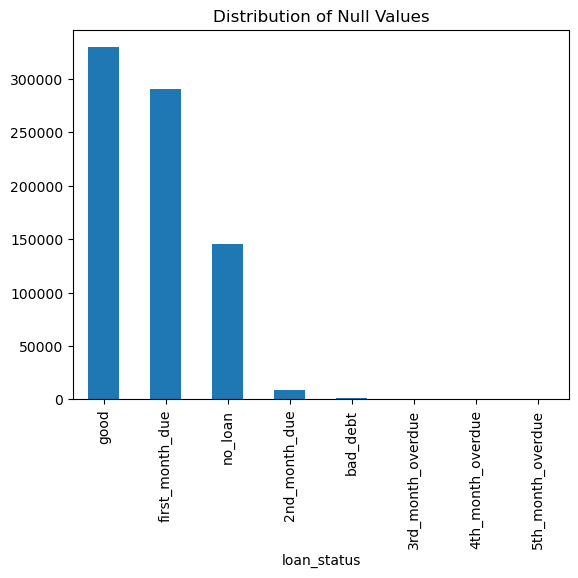

In [127]:
# Plot loan status distribution
plt.title('Distribution of Null Values')
data['loan_status'].value_counts().plot(kind = 'bar')

In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  777715 non-null  int64  
 1   gender              777715 non-null  object 
 2   own_car             777715 non-null  object 
 3   own_property        777715 non-null  object 
 4   num_of_children     777715 non-null  int64  
 5   total_income        777715 non-null  float64
 6   income_type         777715 non-null  object 
 7   education           777715 non-null  object 
 8   family_status       777715 non-null  object 
 9   housing_type        777715 non-null  object 
 10  age_in_days         777715 non-null  int64  
 11  employment_in_days  777715 non-null  int64  
 12  mobile              777715 non-null  int64  
 13  work_phone          777715 non-null  int64  
 14  phone               777715 non-null  int64  
 15  email               777715 non-nul

In [131]:
# Lets map the age_in_days and employment_in_days values
data['age'] = data['age_in_days'].apply(lambda x: abs(x) // 365)

# Calculate years employed and unemployment status
data['employment_years'] = data['employment_in_days'].apply(lambda x: abs(x) // 365)
data['is_unemployed'] = data['employment_in_days'].apply(lambda x: 1 if x > 0 else 0)

data.drop('age_in_days', axis='columns', inplace=True)
data.drop('employment_in_days', axis='columns', inplace=True)
print(f'Dropped size column: {data.shape}')

Dropped size column: (777715, 21)


In [132]:
# Calculate credit history length
credit_history_length = data.groupby('ID')['months_balance'].apply(lambda x: x.max() - x.min()).reset_index()
credit_history_length.columns = ['ID', 'credit_history_length']
data = pd.merge(data, credit_history_length, on='ID', how='left')

data.drop('months_balance', axis='columns', inplace=True)
print(f'Dropped size column: {data.shape}')

Dropped size column: (777715, 21)


In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     777715 non-null  int64  
 1   gender                 777715 non-null  object 
 2   own_car                777715 non-null  object 
 3   own_property           777715 non-null  object 
 4   num_of_children        777715 non-null  int64  
 5   total_income           777715 non-null  float64
 6   income_type            777715 non-null  object 
 7   education              777715 non-null  object 
 8   family_status          777715 non-null  object 
 9   housing_type           777715 non-null  object 
 10  mobile                 777715 non-null  int64  
 11  work_phone             777715 non-null  int64  
 12  phone                  777715 non-null  int64  
 13  email                  777715 non-null  int64  
 14  family_members         777715 non-nu

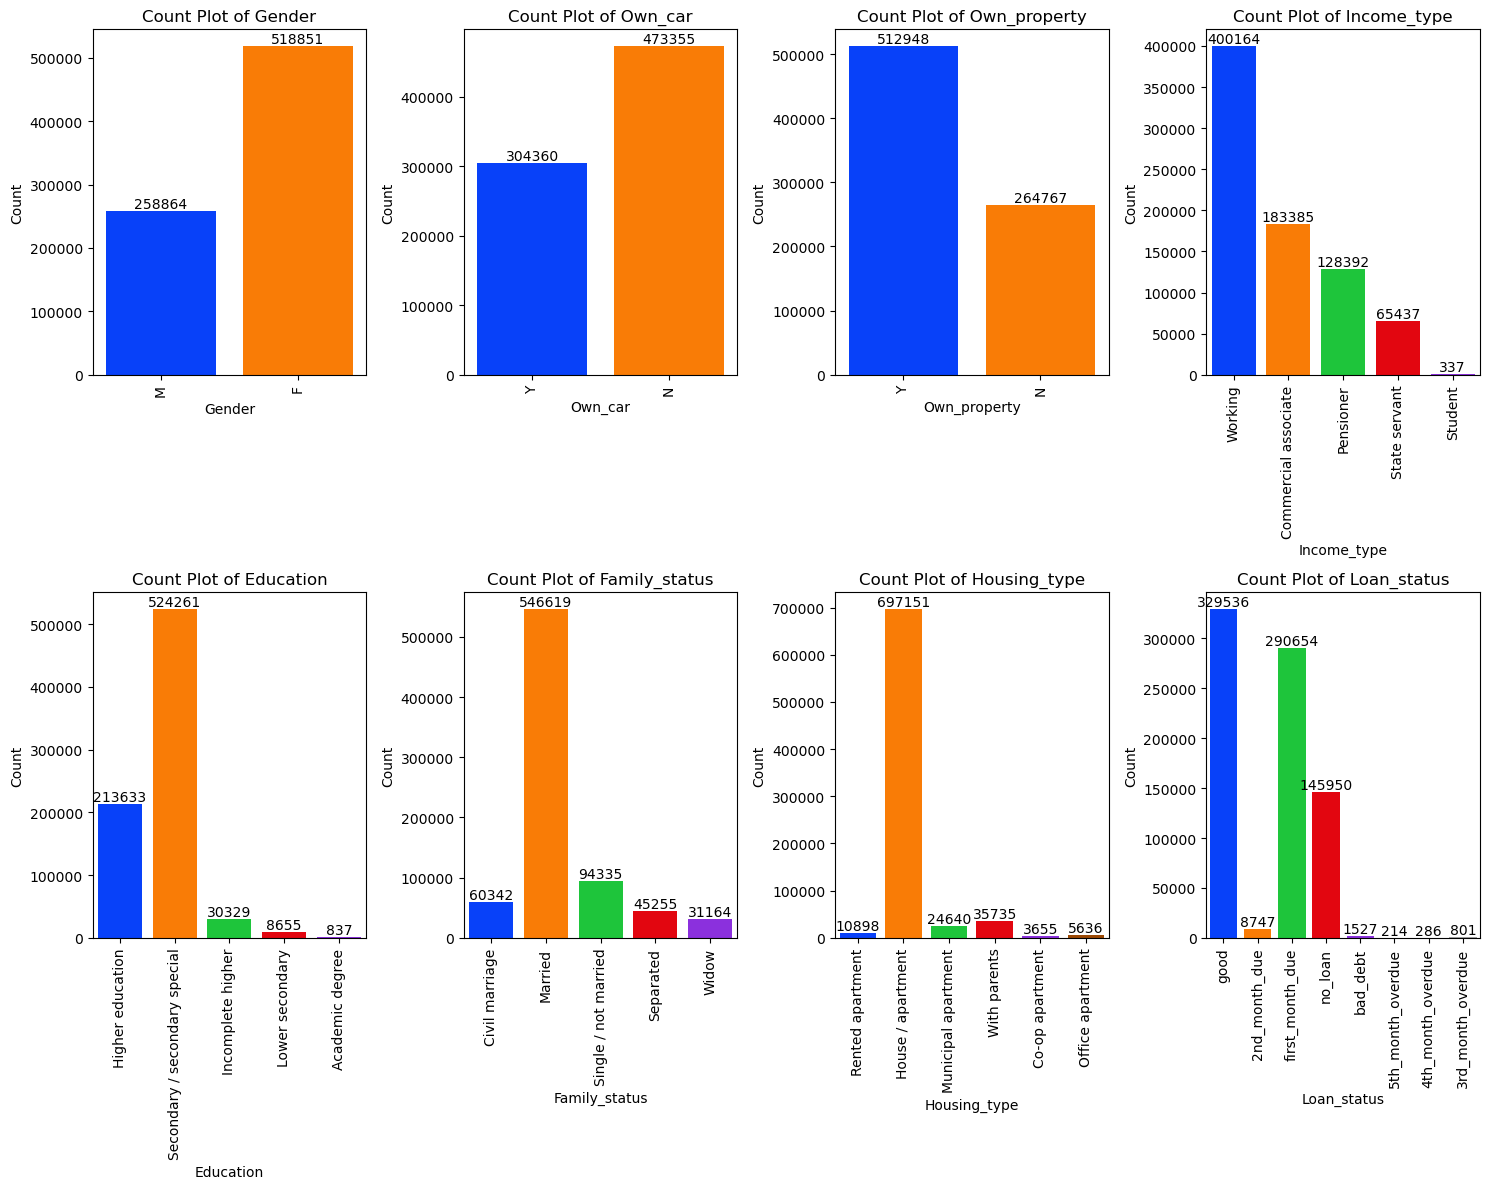

In [137]:
# Distribution of Categorical Features

# List of categorical columns to analyze
categorical_columns = ['gender', 'own_car', 'own_property', 'income_type', 
                       'education', 'family_status', 'housing_type', 'loan_status']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
axes = axes.ravel()  

# Loop through each categorical column
for i, column in enumerate(categorical_columns):
    sns.countplot(x=data[column], data=data, palette='bright', ax=axes[i], saturation=0.95)
    for container in axes[i].containers:
        axes[i].bar_label(container, color='black', size=10)
    axes[i].set_title(f'Count Plot of {column.capitalize()}')
    axes[i].set_xlabel(column.capitalize())
    axes[i].set_ylabel('Count')
    axes[i].tick_params("x", rotation=90)

# Adjust layout and show plots
plt.tight_layout()
plt.show()

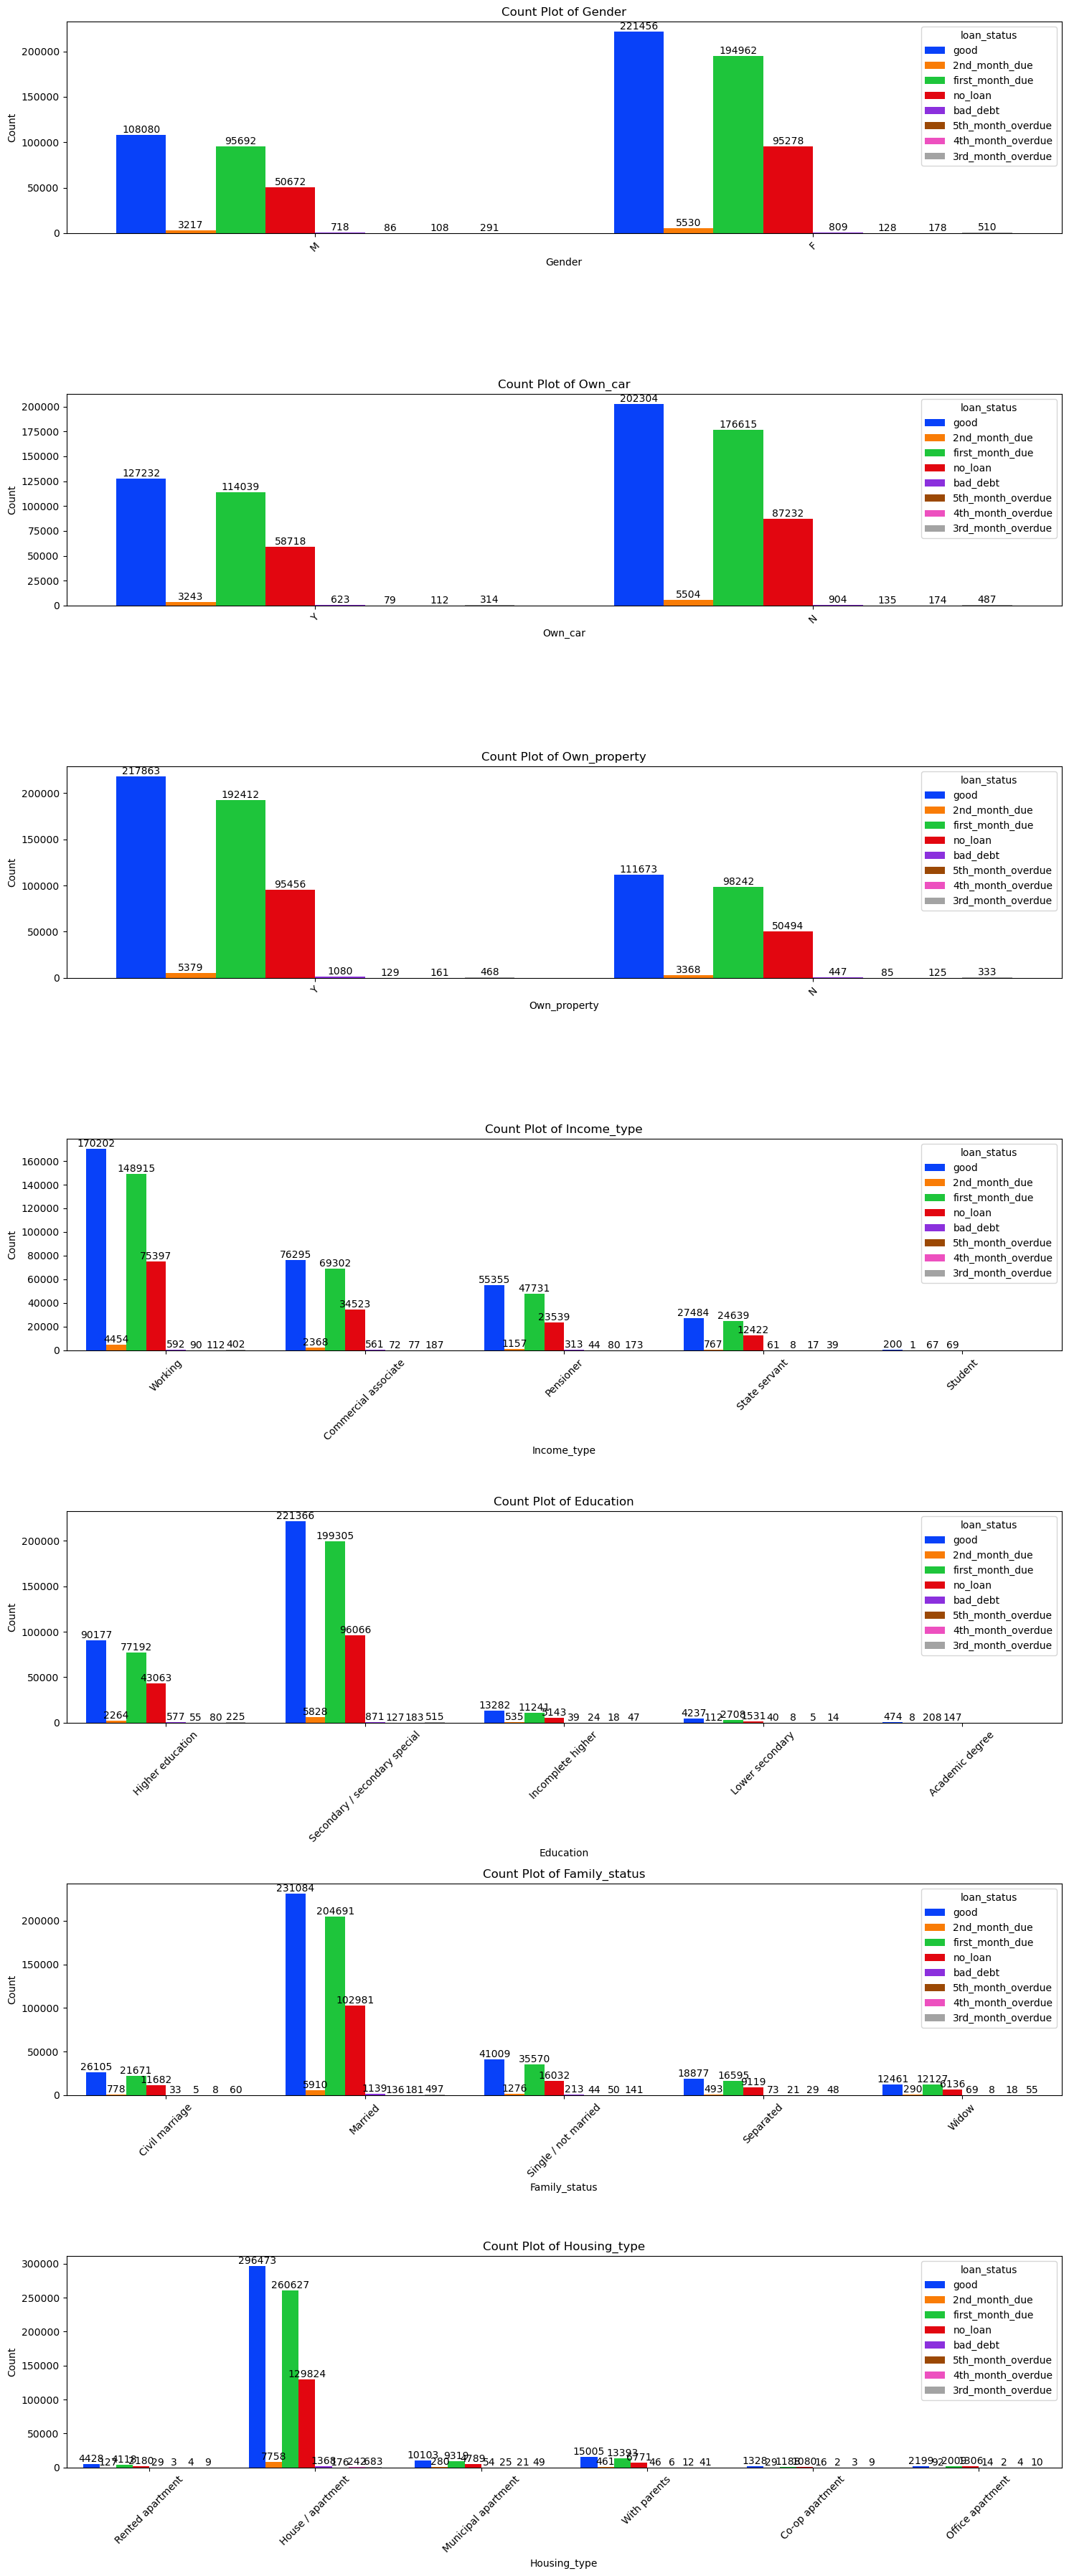

In [138]:
# Distribution of Categorical Features by loan_status

# List of categorical columns to analyze
categorical_columns = ['gender', 'own_car', 'own_property', 'income_type',
                       'education', 'family_status', 'housing_type']

# Create subplots
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 36))
axes = axes.ravel()  

# Loop through each categorical column
for i, column in enumerate(categorical_columns):
    sns.countplot(x=data[column], data=data, palette='bright', ax=axes[i], saturation=0.95, hue=data['loan_status'])
    for container in axes[i].containers:
        axes[i].bar_label(container, color='black', size=10)
    axes[i].set_title(f'Count Plot of {column.capitalize()}')
    axes[i].set_xlabel(column.capitalize())
    axes[i].set_ylabel('Count')
    axes[i].tick_params("x", rotation=45)

# Adjust layout and show plots
plt.tight_layout()
plt.show()

### Data Observations for Categorical columns
1. Loan status which is our target label is imbalanced  
2. We have more Female members v/s male members. Females are higher in each category of loan status as compared males
3. People who dont own a car seem to make more regular loan payments
4. People who own a property seem to make more regular loan payments
5. People with Secondary education take more credit card loans
6. People who live in owned house or apartment take more loans and also make regular payments 
7. Married people take more loans and also make regular payments

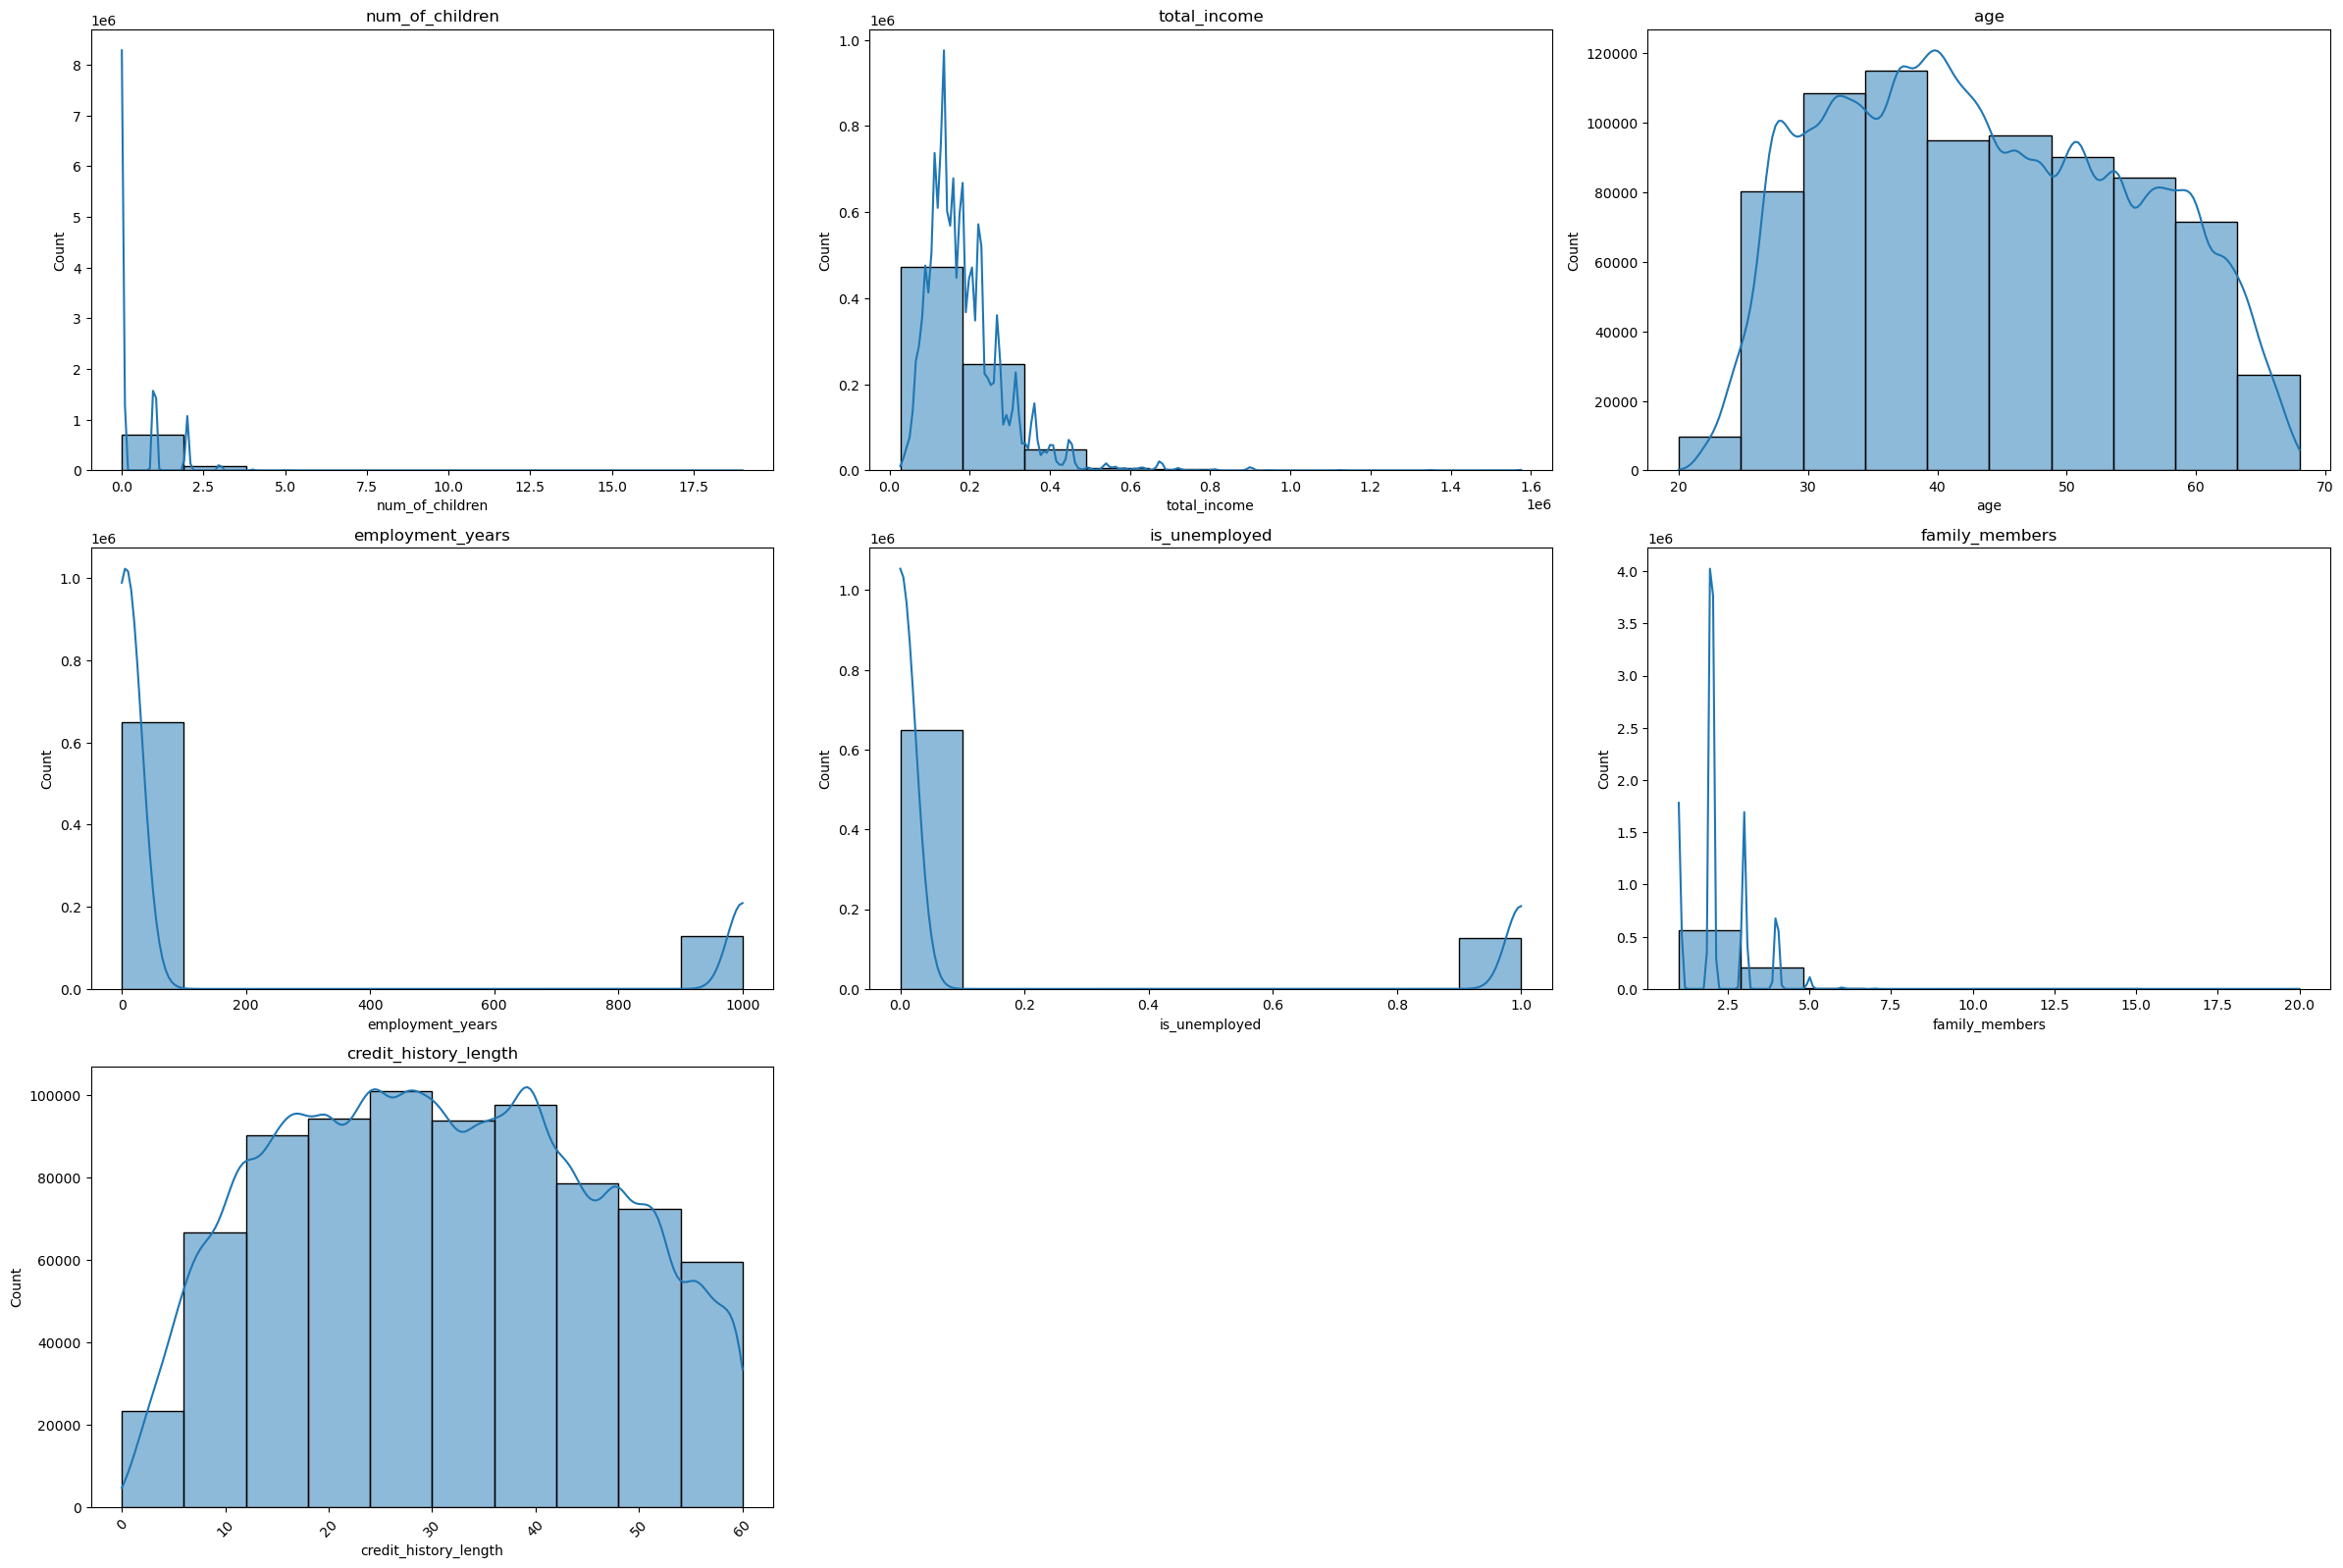

In [140]:
# Distribution of Numerical Features
numerical_features = ['num_of_children', 'total_income', 'age', 'employment_years', 'is_unemployed', 'family_members', 'credit_history_length']

plt.figure(figsize=(24, 16))
for feature in numerical_features:
    plt.subplot(3, 3, numerical_features.index(feature) + 1)
    sns.histplot(data=data[feature], bins=10, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.ticklabel_format(useOffset=False, style='plain', axis='x')
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.tick_params("x", rotation=45)
plt.show()

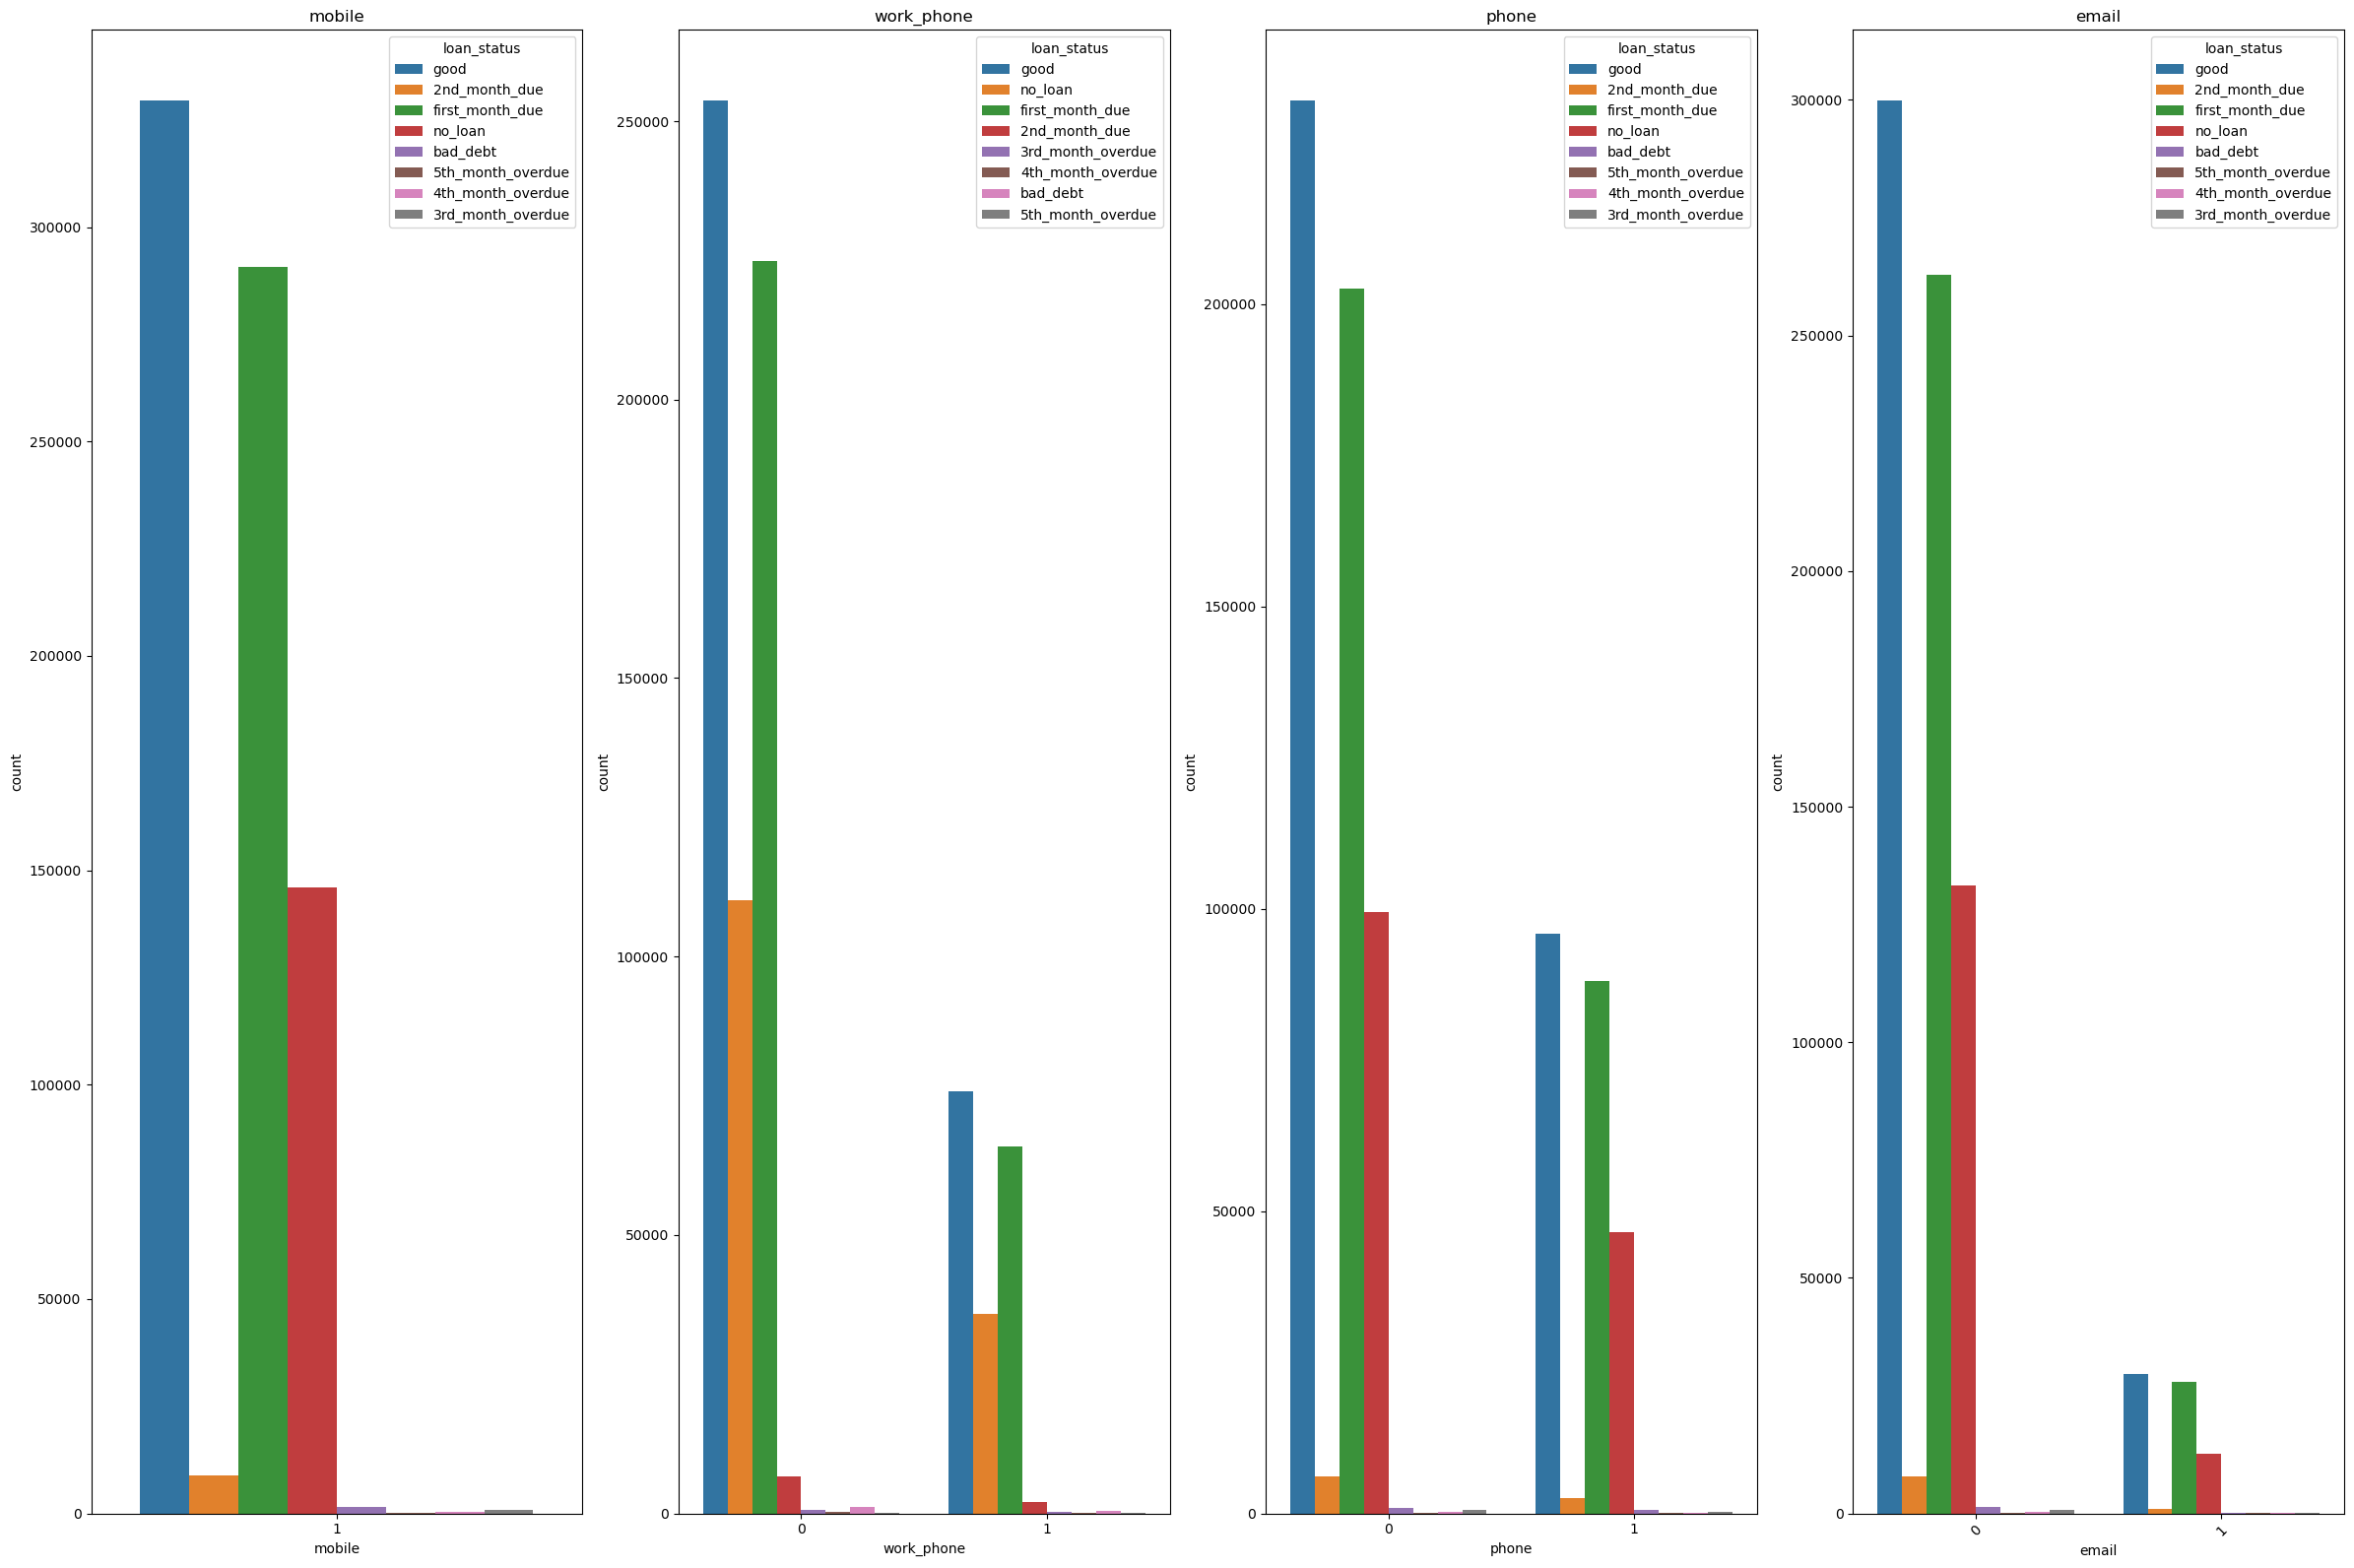

In [141]:
# checking the relationship between loan status and income type
numerical_features_2 = ['mobile', 'work_phone', 'phone', 'email']

plt.figure(figsize=(24, 16))
for feature in numerical_features_2:
    plt.subplot(1, 4, numerical_features_2.index(feature) + 1)
    sns.countplot(data=data, x=data[feature], hue=data['loan_status'])
    plt.title(feature)
plt.tight_layout()
plt.tick_params("x", rotation=45)
plt.show()


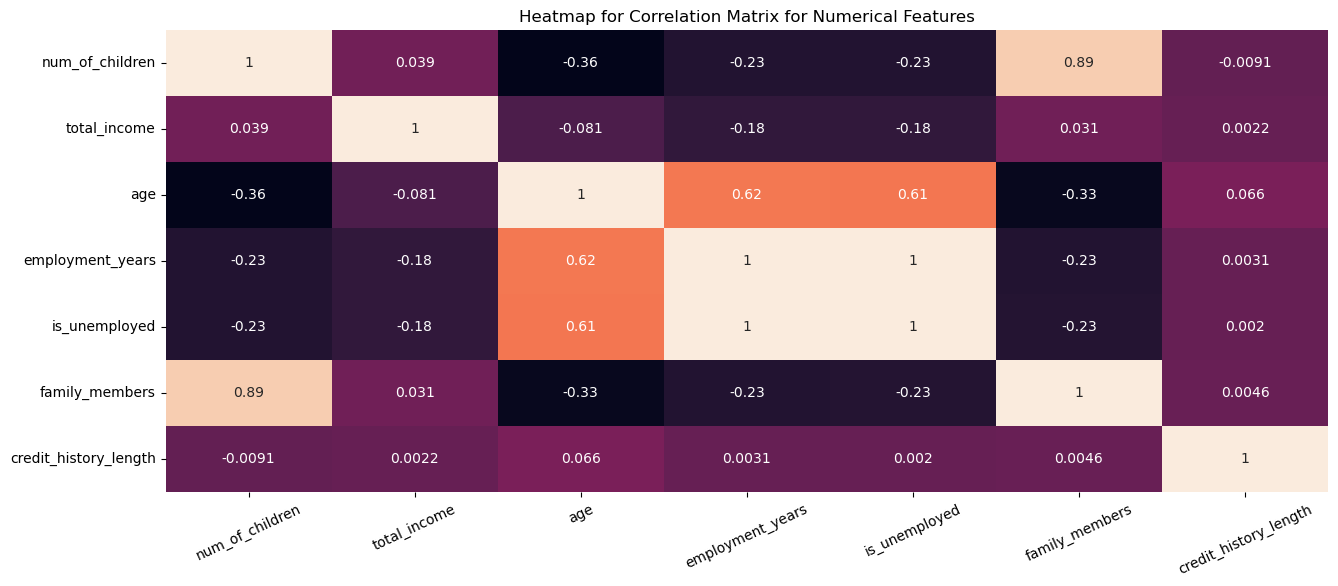

In [142]:
# Correlation Analysis

# defining the figure size
plt.figure(figsize=(15, 6))
# plotting the heatmap
sns.heatmap(data[['num_of_children', 'total_income', 'age', 'employment_years', 'is_unemployed', 'family_members', 'credit_history_length']].corr(), annot=True , cbar=False) 
# defining the title and rotation of x-axis labels
plt.xticks(rotation=25)
plt.title('Heatmap for Correlation Matrix for Numerical Features')
plt.show()

<Figure size 2400x1600 with 0 Axes>

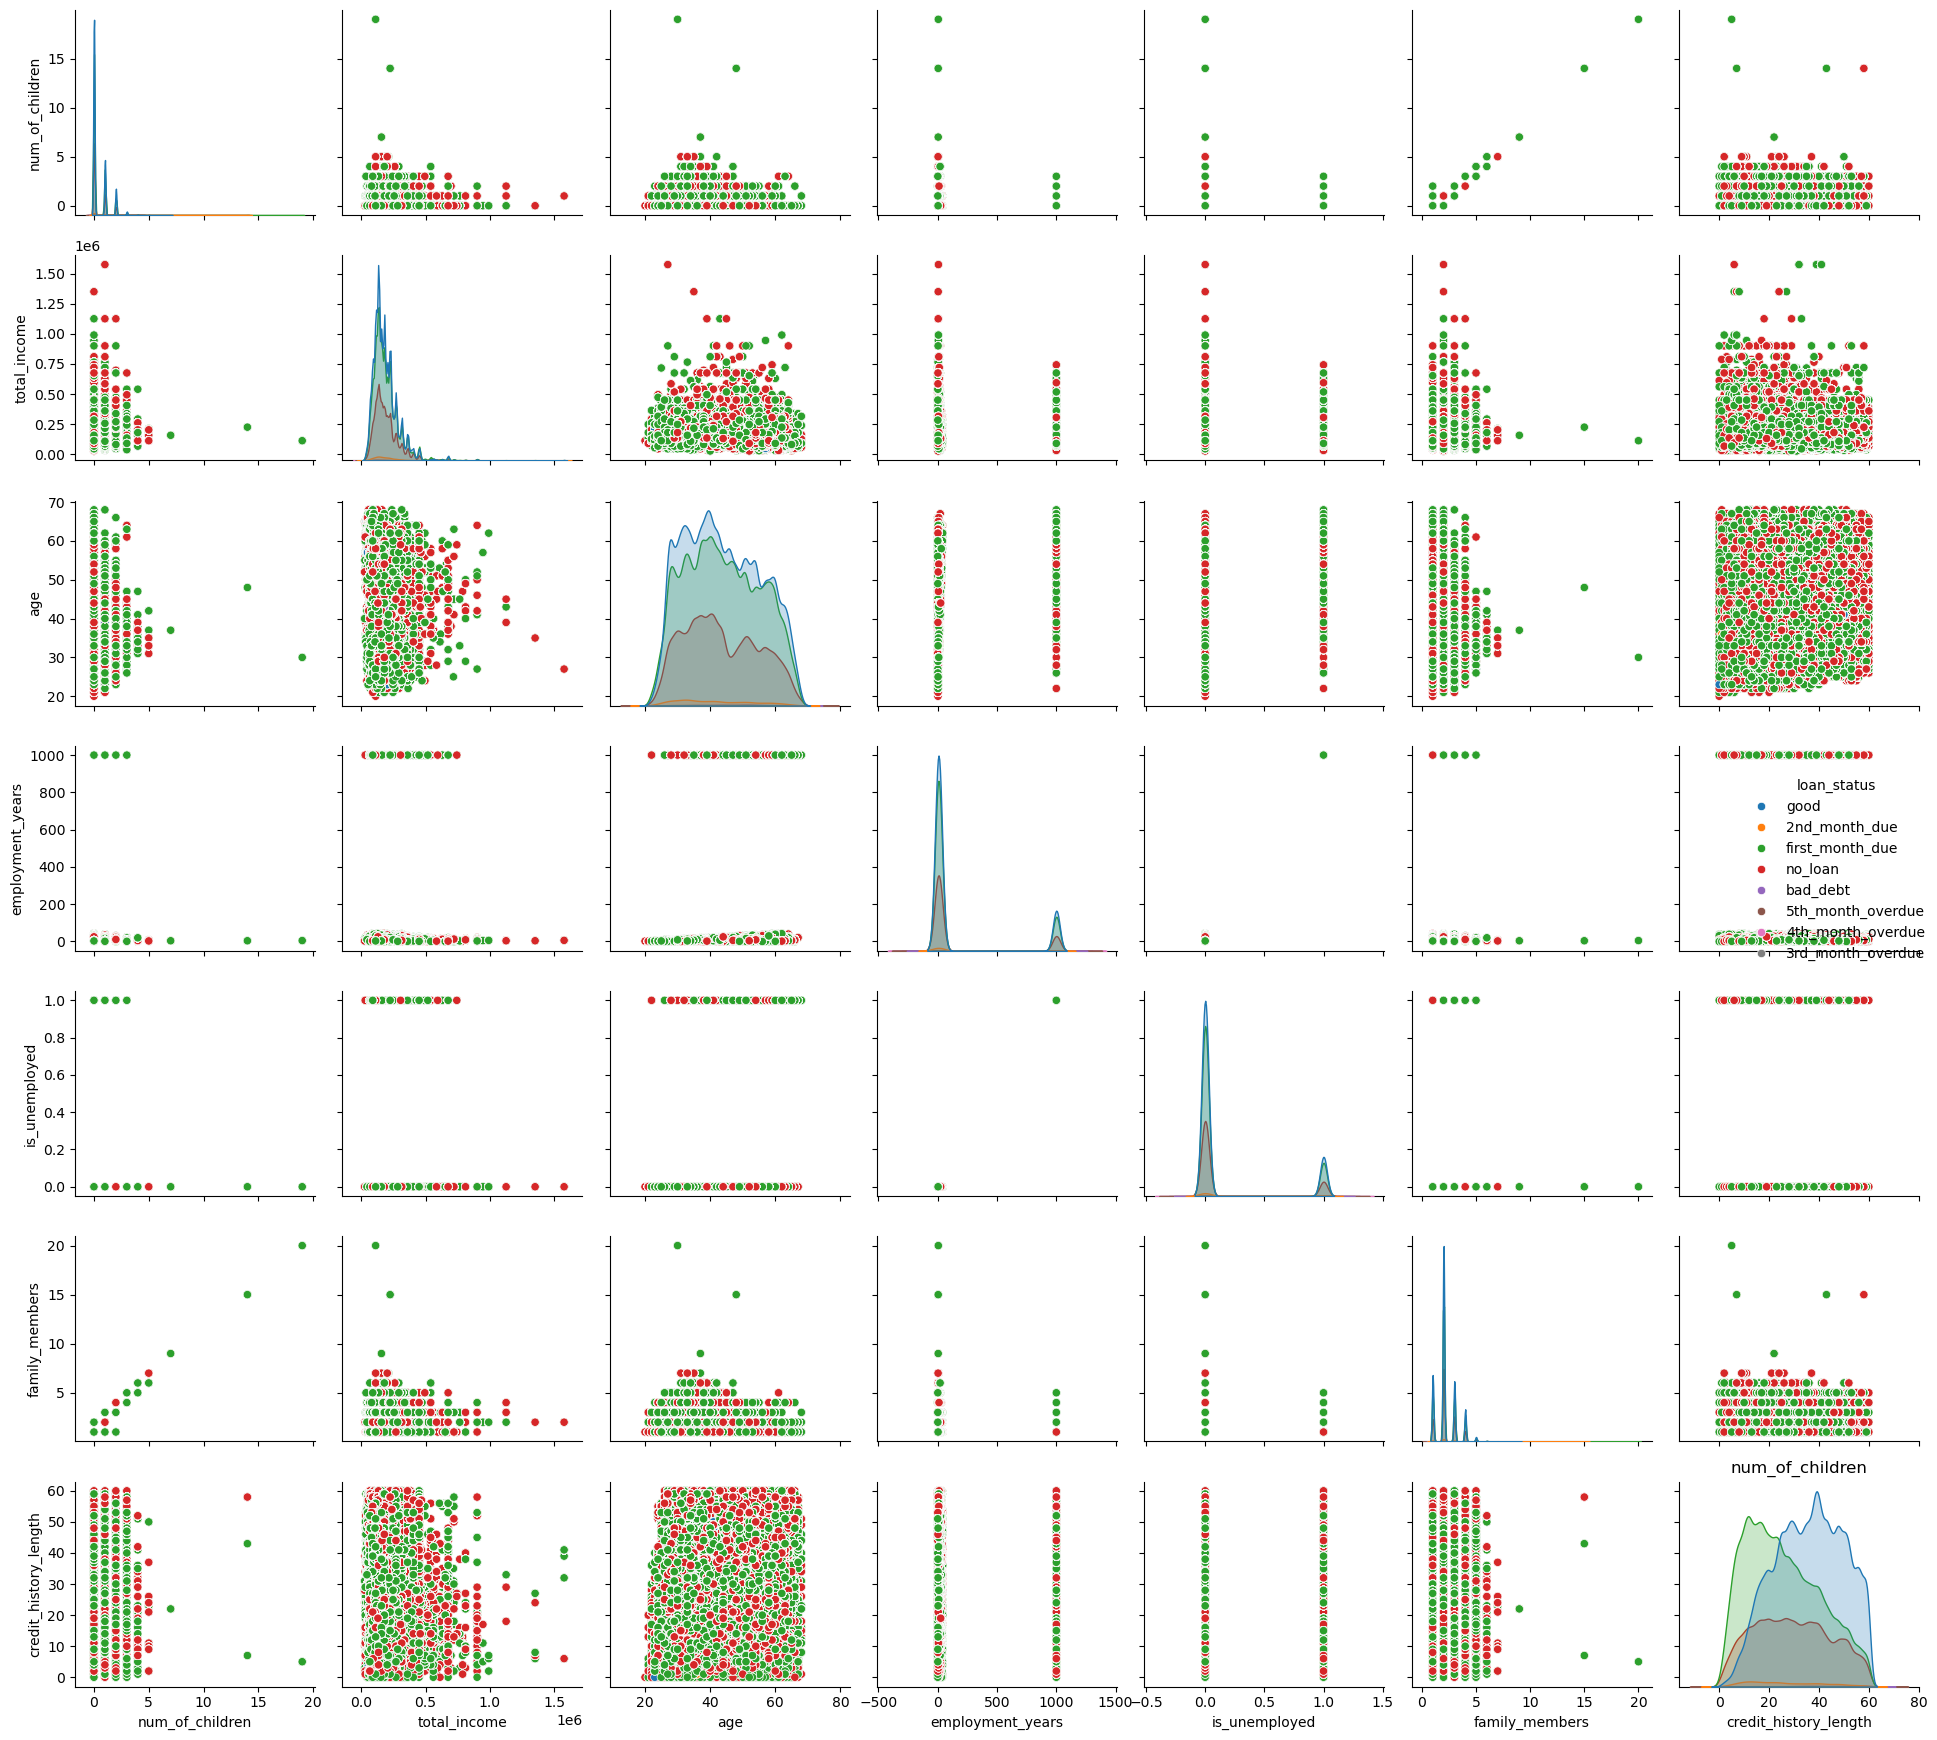

In [306]:
# Scatter plot for numerical columns by loan status

plt.figure(figsize=(24, 16))
sns.pairplot(data[['num_of_children', 'total_income', 'age', 'employment_years', 'is_unemployed', 'family_members', 'credit_history_length', 'loan_status']], hue='loan_status')
plt.title(feature)
plt.tight_layout()
plt.ticklabel_format(useOffset=False, style='plain', axis='x')
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.tick_params("x", rotation=45)
plt.show()

### Data Observations for Numerical columns
1. Family members and number of children columns have a high corelation.
2. Age and is_unemployed also has high corelation

### Feature Engineering

We will build a basic model to get started.  Before we can do this, we must work to encode the data.  Let's prepare the features and target column for modeling with appropriate encoding and transformations.

In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     777715 non-null  int64  
 1   gender                 777715 non-null  object 
 2   own_car                777715 non-null  object 
 3   own_property           777715 non-null  object 
 4   num_of_children        777715 non-null  int64  
 5   total_income           777715 non-null  float64
 6   income_type            777715 non-null  object 
 7   education              777715 non-null  object 
 8   family_status          777715 non-null  object 
 9   housing_type           777715 non-null  object 
 10  mobile                 777715 non-null  int64  
 11  work_phone             777715 non-null  int64  
 12  phone                  777715 non-null  int64  
 13  email                  777715 non-null  int64  
 14  family_members         777715 non-nu

In [148]:
data.head(5)

,ID,gender,own_car,own_property,num_of_children,total_income,income_type,education,family_status,housing_type,...,work_phone,phone,email,family_members,status,loan_status,age,employment_years,is_unemployed,credit_history_length
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,2.0,C,good,32,12,0,15
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,2.0,C,good,32,12,0,15
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,2.0,C,good,32,12,0,15
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,2.0,C,good,32,12,0,15
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,2.0,C,good,32,12,0,15


In [149]:
X = data.drop(['loan_status' , 'status'], axis=1)
y = data['loan_status']

le = LabelEncoder()
y = le.fit_transform(y)

# List of Categorical Features/Columns
categorical_columns = ['gender', 'own_car', 'own_property', 'income_type', 'education', 'family_status', 'housing_type']
# Distribution of Numerical Features/Columns
numerical_columns = ['num_of_children', 'total_income', 'age', 'employment_years', 'is_unemployed', 'family_members', 'credit_history_length']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

In [151]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [158]:
# Create a pipeline
lgr_pipe = Pipeline([('Preprocessor', preprocessor), 
                     ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])
lgr_pipe

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['num_of_children',
                                                   'total_income', 'age',
                                                   'employment_years',
                                                   'is_unemployed',
                                                   'family_members',
                                                   'credit_history_length']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'own_car',
                                                   'own_property',
                                                   'income_type', 'education',
                                                   'family_status',
                                                   'housing_type'])])),
                ('lgr', LogisticRegression(max_iter=1000, random_state=42))])

In [160]:
lgr_pipe.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['num_of_children',
                                                   'total_income', 'age',
                                                   'employment_years',
                                                   'is_unemployed',
                                                   'family_members',
                                                   'credit_history_length']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'own_car',
                                                   'own_property',
                                                   'income_type', 'education',
                                                   'family_status',
                                                   'housing_type'])])),
                ('lgr', LogisticRegression(max_iter=1000, random_state=42))])

In [161]:
lgr_pipe_acc = lgr_pipe.score(X_test, y_test)
print(f'Simple Logistic Regression accuracy : {lgr_pipe_acc}')

Simple Logistic Regression accuracy : 0.5179918093388967


In [162]:
# Random Forest Classifier model
# forest = RandomForestClassifier()
forest_pipe = Pipeline([('Preprocessor', preprocessor), 
                     ('forest', RandomForestClassifier())])

forest_pipe.fit(X_train, y_train)
# making predictions on the test set
y_pred = forest_pipe.predict(X_test)
print(f'Accuracy Score : {accuracy_score(y_test, y_pred)*100:.2f} %')

Accuracy Score : 73.88 %


In [163]:
default_models = {
    'knn': (KNeighborsClassifier(n_neighbors=5)),
    # 'svc': (SVC()),
    'decisiontreeclassifier': (DecisionTreeClassifier(max_depth=5, random_state=42))
}

default_mod_results = []

for name, (model) in default_models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    print(f'Created pipeline for model - {name}')
    
    # Fit the model and time it
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    fit_time = (time.time() - start_time)
    print(f'Training complete for model - {name}')
    
    # Evaluate on training and test sets
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    print(f'Scoring complete for model - {name}')
        
    # Append the results
    default_mod_results.append([name, fit_time, train_score, test_score])
    print(f'Finished appending results for model - {name}')
    

# Create the results DataFrame
default_mod_results_df = pd.DataFrame(default_mod_results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])

# Display the DataFrame
print(default_mod_results_df)

Created pipeline for model - knn
Training complete for model - knn
Scoring complete for model - knn
Finished appending results for model - knn
Created pipeline for model - decisiontreeclassifier
Training complete for model - decisiontreeclassifier
Scoring complete for model - decisiontreeclassifier
Finished appending results for model - decisiontreeclassifier
                    Model  Train Time  Train Accuracy  Test Accuracy
0                     knn    0.736019        0.726944       0.711199
1  decisiontreeclassifier    1.546856        0.522704       0.524459


In [170]:
default_mod_results = []

for name, (model) in default_models.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    print(f'Created pipeline for model - {name}')
    
    # Fit the model and time it
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    fit_time = (time.time() - start_time)
    print(f'Training complete for model - {name}')
    
    # making predictions on the test set
    y_pred = pipeline.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(f'Accuracy Score : {accu_score*100:.2f} %')
    print(f'Scoring complete for model - {name}')
    
    # Append the results
    default_mod_results.append([name, fit_time, accu_score])
    print(f'Finished appending results for model - {name}')
    

# Create the results DataFrame
default_mod_results_df = pd.DataFrame(default_mod_results, columns=['Model', 'Train Time', 'Accuracy Score'])

# Display the DataFrame
print(default_mod_results_df)

Created pipeline for model - knn
Training complete for model - knn
Accuracy Score : 71.12 %
Scoring complete for model - knn
Finished appending results for model - knn
Created pipeline for model - decisiontreeclassifier
Training complete for model - decisiontreeclassifier
Accuracy Score : 52.45 %
Scoring complete for model - decisiontreeclassifier
Finished appending results for model - decisiontreeclassifier
                    Model  Train Time  Accuracy Score
0                     knn    0.804967        0.711199
1  decisiontreeclassifier    1.566140        0.524459
